## homework 05: a mixture of five


In [1]:
# Import packages required for PSET
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import scipy.special     as special
import scipy.misc        as misc
import scipy.stats       as stats

# GLOBAL Variables
K = 5 # Number of clusters we want K-means to cluster for
EUCLID = True # Toggle for part 1 and part 3 to not copy code, 
              # calculate distance not in logspace when true

### 1. reproduce Wiggins' K-means 

Below I will use pandas to read and clean my table very quickly. Next, I will define many functions that implement the K-means clustering we want in this question with the hopes that many parts can be re-used for parts 2 and 3, just as I did in PSET 04. Each function includes comments on purpose, input, and output. 

In [2]:
# Read and clean tabular data
data = pd.read_csv('w05-data.tbl', sep = '\s+') # Read dataframe
data.rename(columns={'#cell':'cell'}, inplace = True) # Clean column headers
data.set_index('cell', inplace = True) # Let cell no. be index
#data #output to view data

# Change points to plot to numpy array
X = data[["caraway","kiwi"]].to_numpy()
print(X)

[[2311 2722]
 [ 633  369]
 [2509 1259]
 ...
 [  34  481]
 [ 107   63]
 [ 322  147]]


In [3]:
# Calculate shape of our data to use below:
x, y = np.shape(X)

#### 1) K-means assignment step
Next, I know I need to write functions for my assignment step:


$k$ clusters are created by assigning each data point $X_i$ to the nearest centroid $\mu_k$ based on their Euclidian distance in z dimensions $\sqrt{\sum_{z} (X_{iz}-\mu_{kz})^2}$.


**To Do**: Assign each data point X_i to its closest centroid μ_k

I need at least one function here to randomly generate centroids, `generate_centroids()`. Next, I need to assign my datapoints to the closest centroids, which I will do with `assign()`. I create a helper function `euclid()` to calculate my euclidean distance for me.


In [4]:
"""
FUNCTION to initialize centroids by choosing K random points in space encompassed by points X
Inputs: X = Array of data to classify, K = Clusters desired
Output: centroids = Array of centroids
"""
def generate_centroids(X, K):
    mu = np.zeros(y) # Create mu array to be of shape our coordinates, in this case 2D
    centroids = np.zeros((K, y)) # Create centroid array to be K x y of points, e.g. 5 x 2
    
    min_d = np.amin(X, axis = 0) # Take minimum point plotted along x,y
    max_d = np.amax(X, axis = 0) # Take maximum point plotted along x,y
    
    # Randomly create a point within those values, and assign to centroid array
    for i in range (K):
        for j in range (y):
            rmin = np.log(min_d[j])
            rmax = np.log(max_d[j])
            logprob = np.random.uniform(rmin, rmax)
            mu[j] = np.exp(logprob)
        centroids[i] = mu
    return centroids

I know k-means is dependent on calculating euclidean distance, so I will first write a function that does that for me.

In [5]:
"""
FUNCTION to calculate euclidean distance given two vector arrays, a & b
Can also calculate in logspace based on global variable EUCLID
Inputs: a, b = Arrays
Output: distance = Distance between vectors
"""
def euclid(a, b):
    distance = 0.
    for i in range(len(a)):
        if EUCLID:
            distance += (a[i] - b[i]) ** 2
        else:
            distance += (np.log(a[i]) - np.log(b[i])) ** 2
    return np.sqrt(distance)

In [6]:
"""
FUNCTION that assigns X points to centroids 
Inputs: X = Array of points, centroids = array of centroid coordinates
Outputs: clusters = Array of index of clusters, tot_sqdist as Float
"""
def assign (X, centroids):
    clusters = np.zeros(len(X)).astype(int) # Create array for groupings
    tot_sqdist = 0 # Initialize total square distance calculation that we will keep track of
    
    # Enumerate over all points to assign them and calculate tot_sqdist
    for i, point in enumerate(X):
        opt_distance = euclid(point, centroids[0]) # Initialize optimum distance for single point
        opt_centroid = 0 # Initialize optimum centroid index
        
        # Calculate closest centroid to point
        for centroid in range (1, K):
            distance = euclid(point, centroids[centroid])
            if distance < opt_distance:
                opt_distance = distance
                opt_centroid = centroid
                
        # Set point to optimum centroid and add to tot_sqdist measure
        clusters[i] = opt_centroid
        dist = opt_distance 
        tot_sqdist += dist ** 2
    
    return clusters, tot_sqdist

#### 2) K-means update step
Great! Now I have completed the first step of my K-means algorithim, the assignment step. Next, I need to complete my update step and create the new ideal centroids and iterate until they do not change. The centroid of the clusters are updated by calculating the mean of all points assigned to that cluster using $\mu_{kz}=\frac{\sum_{i\in{C_k}} X_{iz}}{|C_k|}$.  I will write a function that does this called `update()`.

In [7]:
"""
FUNCTION that updates centroids given clustering clusters and points X
Inputs: X = Array of points, clusters = index of cluster
Outputs: New centroid coordinates, number of observations in each cluster
"""
def update (X, K, clusters):
    
    # Assign arrays to store Ck and new centroid coordinates
    cluster_count = np.zeros(K)
    new_centroids = np.zeros((K, y))
    
    # Summing across numerators and denominators for calulations
    for i in range(x):
        index = clusters[i]
        cluster_count[index] += 1 # Denominator
        for j in range(y):
            new_centroids[index, j] += X[i][j] # Numerator
    
    # Average position of each point assigned to each cluster to get the updated centroids
    for i in range(K):
        if cluster_count[i] > 0: # If cluster has no points, ignore 
            new_centroids[i] = np.divide(new_centroids[i], cluster_count[i])

    return new_centroids, cluster_count

In [8]:
"""
FUNCTION that implements hard k-means algorithim with euclidean distance
Inputs: X = points to cluster, K = number of clusters
Output: centroids = coordinates of centroids, clusters = index map of points to cluster
        fraction = percentage of observations in each cluster, tot_sqdist = euclidean metric to minimize
"""

def kmeans (X, K):
    # Inner function that determines when to stop iteration
    def stop (a, b):
        count = 0
        for i in range(len(a)):
            if a[i] != b[i]:
                count += 1
        return (count == 0)
    
    centroids = generate_centroids(X, K) # Generate Centroids
    
    # Initiate k-means algorithim once
    clusters, tot_sqdist = assign(X, centroids)
    centroids, cluster_count = update(X, K, clusters)
    old_clusters = clusters
    
    # Continue iteration until there is no difference    
    while True:
        clusters, tot_sqdist = assign(X, centroids)
        if stop(old_clusters, clusters):
            break
        centroids, cluster_count = update(X, K, clusters)
        old_clusters = clusters
    
    # Calculate the "fraction" in Wiggin's table
    fraction = np.divide(cluster_count, np.sum(cluster_count))
    
    return centroids, clusters, fraction, tot_sqdist

Great! Now using the visualization code provided by Sean to create our log-log graphs below, we can see how our clustering algorithim works:

In [9]:
def visualize_data(data, mu, C):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')

I wrote a function below that runs my k-means implementation for 'runs' number of times. It then outputs the result of the best run, which is the run with the lowest total squared distance. 

In [10]:
def best_kmeans(X, K, runs):
    # One run of kmeans to initialize values
    centroids, clusters, fraction, totsqdist = kmeans(X,K)
    centroids_best = centroids
    clusters_best = clusters
    fraction_best = fraction
    min_dist = totsqdist
    best_run = 1
    
    # Repeat for # of runs specified
    for i in range(runs - 1):
        centroids, clusters, fraction, totsqdist = kmeans(X,K)

        # Save clusters and centers if it has minimal sum distance to date
        if totsqdist < min_dist:            
            min_dist = totsqdist
            clusters_best = clusters 
            centroids_best = centroids
            fraction_best = fraction
            best_run = i + 1
    
    # Visualize only the best result
    visualize_data(X, centroids_best, clusters_best)
    
    # Print out results similar to Wiggins
    headers = ["clusters", "fraction", "Caraway", "Kiwi"]
    lst = [[i+1, fraction_best[i], centroids_best[i,0], centroids_best[i,1]] for i in range(K)]
    df = pd.DataFrame(lst, columns = headers)
    print(df)
    print ("This solution was run #" + str(best_run) + " and had a tot_sqdist of " + str(min_dist))

   clusters  fraction      Caraway         Kiwi
0         1     0.111  1686.036036   509.063063
1         2     0.070  1996.685714  2806.557143
2         3     0.641   214.424337   236.617785
3         4     0.068  3470.661765   879.279412
4         5     0.110   236.109091  2371.472727
This solution was run #7 and had a tot_sqdist of 349480429.73001033


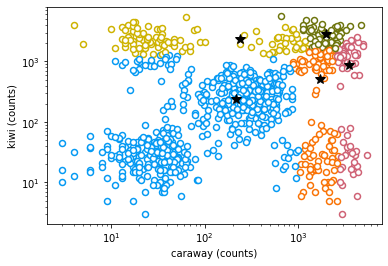

In [11]:
best_kmeans(X,K,20)

#### Conclusion
Well it seems like I'm able to not find the obvious grouping but I have reproduced the results like Wiggins. I hypothesize, given the hint in Q3, that the fact that Sean's function graphs this in log-log space (and our distance being euclidean) may have something to do with not getting perfect results.

### 02. mixture negative binomial fitting

#### 1) Expectation
During this step, we implement the equivalent of the assignment step in euclidean kmeans. Here, we are going to calculate the posterior probability $P(q|x, \theta)$ for each data point $x$ coming from each component $q$, knowing our model $\theta$. As in section, the parameters for the mixture model will be stored in an array.

#### Calculating the log-likelihood of a model
The likelihood of a model is defined as the probability that the observations are generated from the model. We can therefore use log-likelihood to compare the models and choose the one that has the highest likelihood - that is, the smallest negative log-likelihood.

Since we will already be storing and iterating over prior probabilities in order to get the posterior probability by defintion, we can also use the below function to calculate the negative log likelihood by using `logsumexp` of the numerator of the posterior before normalizing. 

In [12]:
def expectation(X, mus, phi, mix_coeffs):
    '''
    Return the Posterior Probability of each data point coming from each component 
    and current cluster assignment for each point
    
    Parameters
    ----------
    X       : 2D array, list X-coordinates of all points
    mus            : 2D array, list of current estimates for component means
    phi         : float, set parameter for dispersion
    mix_coeffs: 1D array, list of current estimates for mixture coefficients of components
    
    Returns
    -------
    posts     : 2D array, posterior probabilities of each component being the source of each point.
    -ll       : float, negative log likelihood
    '''
        
    # Initialize P(q|x, theta), total  log likelihood
    posts = np.zeros((x, K))
    total_ll = 0
    
    # Loop through points
    for i in range(x): 
        # Append the probability that the point is generated by each component
        for j in range (K):
            posts[i][j] = np.log(mix_coeffs[j])
            for k in range (y):
                posts[i][j] += stats.nbinom.logpmf(X[i][k],1 / phi, 1 / (1 + mus[j][k] * phi))
        
        # Normalize to obtain the posterior probability that each data point comes from each component
        #Double-win: easily calculate the negative log-likelihood without having to make another function like in section
        ll = special.logsumexp(posts[i])
        total_ll += ll
        posts[i] = np.subtract(posts[i],ll)
        posts[i] = np.exp(posts[i])
    
    return posts, -total_ll

#### 2) Maximization
This step is analagous to the update step in euclidean k-means. During this step, we update the centroids $\mu_q$ and mixture coefficients given the posterior probabilities.

In [13]:
def maximization(X, posts):
    '''
    Return the updated mus and mixture coefficients for each component
    
    Parameters
    ----------
    X       : 2D array, list X-coordinates of all points
    posts          : 2D array, Posterior probabilities of each component being the source of each point
    
    Returns
    -------
    mus           : 2D array, current estimate of component means
    mix_coeffs: array, updated list of extimates for mixture coefficients of components 
    '''
    
    # calculate the new mean for each component q as the posterior weighted average of point positions 
    mus = np.zeros((K, y))
    num_mu = np.zeros((K,y))
    
    # we can first calculate the numerator
    for i in range(x):
        for j in range (K):
            for k in range (y):
                num_mu[j,k] += X[i, k] * posts[i, j]
    
    # now we'll calculate the denominator
    denom_mu = np.sum(posts, axis = 0)
    
    # divide the numerator by denominator to get the weighted means
    for i in range (K):
        if denom_mu[i] > 0: #skip division by zero
            for j in range (y):
                mus[i,j] = num_mu[i,j] / denom_mu[i]
    
    # calculate the new mixture coefficients as the mean of the posteriors
    mix_coeffs = np.divide(denom_mu, x)
    
    return mus, mix_coeffs

#### 3) Iterative EM Algorithm
Our expectation and maximizatin steps are complete! We are now ready to write a function to run our algorithim. As with the previous part, I will first write the function that fits the mixture negative binomial to our data, and then writing a function that chooses the best iterate (based on the total negative log likelihood outputs). 

In [14]:
def fit (X, K, phi, t):
    '''
    Return the updated centroids, clusters, and mixture coefficients
    
    Parameters
    ----------
    X       : 2D array, list X-coordinates of all points
    K       : int, number of clusters
    phi     : int, dispersion 
    t     : float, threshold for negative log likelikehood to end iteration
    
    Returns
    -------
    mus           : 2D array, component means
    mix_coeffs    : 1D array, extimates for mixture coefficients of components 
    clusters      : 1D array, ordered index of which point belongs to which cluster
    nll           : float, nll measure that caused convergence

    '''
    
    mus = generate_centroids(X, K) # Generate Centroids
    mix_coeffs = np.ones(K) # Initialize mixture coefficients
    mix_coeffs = np.divide(mix_coeffs, K) # Normalize
    clusters = np.zeros(x).astype(int) # Initialize cluster assignments
    
    # Start first iteration of EM algorithim
    posts, nll = expectation(X, mus, phi, mix_coeffs)
    nll_old = 0
    mus, mix_coeffs = maximization(X, posts)
    iterate = 0
    
    while (abs(nll_old - nll) > t): # Nll threshold to end iteration 
        nll_old = nll
        posts, nll = expectation(X, mus, phi, mix_coeffs)
        mus, mix_coeffs = maximization(X, posts)
        iterate += 1
        #print ("nll: " + str(nll) + " and iterate: " +str(iterate))
    
    # Choose best cluster 
    for i in range(x):
        clusters[i] = np.argmax(posts[i])

    return mus, clusters, mix_coeffs, nll

Great! Let's see how this algorithim works:

In [15]:
mus, clusters, mix_coeffs, nll = fit(X,K,0.3, 0.01)

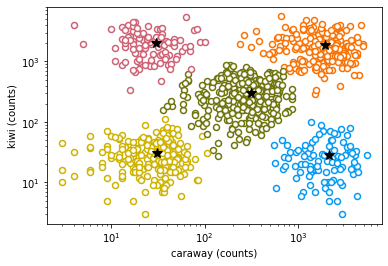

In [16]:
visualize_data(X, mus, clusters)

This is obviously much, much better than my k-means output. I've gotten nll to converge to a pretty good value here (I checked this by uncommenting my print statement in my `fit()` function, but similar to my k-means implementation, I will write a function thats runs this implementation a number of times, and outputs the results from the lowest nll of all runs.

Since this takes a little longer to run, I will use fewer runs.

**NOTE to TF** The below function takes a little while to execute!


In [17]:
def best_fit(X, K, phi, t, runs):
    # One run of kmeans to initialize values
    mus, clusters, mix_coeffs, nll = fit(X,K, phi, t)
    clusters_best = clusters
    mus_best = mus
    coeffs_best = mix_coeffs
    nll_best = nll
    best_run = 1
    
    # Repeat for # of runs specified
    for i in range(runs - 1):
        mus, clusters, mix_coeffs, nll = fit(X,K, phi, t)
        
        # Save clusters and centers if it has minimal sum distance to date
        if nll < nll_best:            
            clusters_best = clusters
            mus_best = mus
            coeffs_best = mix_coeffs
            nll_best = nll
            best_run = i + 1
    
    # Visualize only the best result
    visualize_data(X, mus_best, clusters_best)
    
    # Print out results similar to Wiggins
    headers = ["clusters", "fraction", "Caraway", "Kiwi"]
    lst = [[i+1, coeffs_best[i], mus_best[i,0], mus_best[i,1]] for i in range(K)]
    df = pd.DataFrame(lst, columns = headers)
    print(df)
    print ("This solution was run #" + str(best_run) + " and had a nll of " + str(nll_best))

   clusters  fraction      Caraway         Kiwi
0         1  0.096585  2106.138421    28.432161
1         2  0.204821  1936.394733  1880.993321
2         3  0.105313    30.528543  2047.897832
3         4  0.375155   310.074269   305.960690
4         5  0.218125    31.007961    31.282867
This solution was run #2 and had a nll of 14008.843225050688


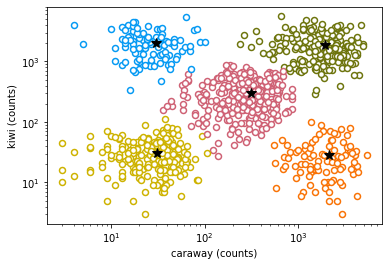

In [18]:
best_fit(X,K,0.3, 0.01, 3)

Even with multiple runs, my algorithim seems to work pretty well and clusters clearly! In the output data table, it seems like with a little bit of rounding, we're getting some really good numbers for percentage of points in each cluster and the centroids of each cluster (for example, the points look like (30, 2000), (30, 30), (2000, 30), etc). 

### 3. find a simple fix for K-means

Our data in part 1 are given in euclidean coordinates, and our distance is calculated in the same space. However, our plots are in log-log space! I think we need to adjust our distance calculations to be done in log-log space!

~To avoid copying code, I am going to define a function below that calculates euclidean distance in log-log space below, and then just add parameters to my k-means implementation (both `kmeans` and `assign` functions) that allow me to swap from one to the other. See `logeuclid` above in my original part one implementation!~

   JUST KIDDING! I did not want to write a bunch of if-statements if the only change in my code is a single line of code that cascades throughout my notebook. Therefore, I went back to change my `euclid()` implementation to include an if-statement that either calculates euclid or logspace distance of my points based on the global variable `EUCLID`. This is set to `True` at the start of my notebook, and I will now change it to `False`. Let's see the results below!

   clusters  fraction      Caraway         Kiwi
0         1     0.110    31.900000  1985.945455
1         2     0.097  2105.731959    28.587629
2         3     0.239    37.029289    38.037657
3         4     0.193  2012.455959  1938.652850
4         5     0.361   336.072022   334.659280
This solution was run #1 and had a tot_sqdist of 789.5511667163071


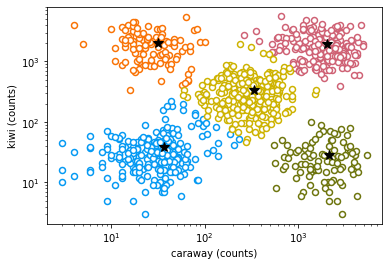

In [19]:
EUCLID = False # calculate in logspace
best_kmeans(X,K,20)

This worked! The takehome message is to calculate distance in log space when graphing on a log-log plot. 